---
title: "Data Collection"
format:
    html: 
        bibliography: ../../assets/references.bib
        nocite: '@*'
        code-fold: false
---

# Goals

The primary goal of this phase was to gather comprehensive data on wrongful convictions and death penalty cases in the United States. By collecting and organizing this data, the aim was to enable in-depth analysis and storytelling that highlights systemic factors influencing convictions and sentencing disparities. The datasets obtained serve as a foundation for identifying patterns, biases, and inequities within the justice system.

![](../../assets/scale.jpg){width=200px align="left"}

# Motivation

- Scraping data from death penalty petitions offers a unique perspective on public advocacy efforts and societal attitudes toward capital punishment. These petitions reflect collective arguments and emotional appeals, often aiming to mobilize public support or sway decision-makers. Performing emotional analysis on petition descriptions allows for an assessment of whether these documents effectively convey emotions such as urgency, empathy, or outrage—critical factors in driving public engagement and influencing policy change.
- Data on individuals who were wrongfully convicted and later exonerated is crucial for understanding the underlying causes of judicial errors. By examining systemic issues such as racial bias, prosecutorial misconduct, and flaws in forensic science, the data provides valuable insights into the vulnerabilities of the justice system. This analysis helps uncover patterns that contribute to wrongful convictions, highlighting areas for reform. 

![](../../assets/light.jpg){width=200px align="left"}

# Objectives

- Collect data on exonerees from the Innocence Project website, including details such as name, state, charge, conviction, sentence, and exoneration.
- Extract petition information related to the death penalty from the Action Network platform.
- Leverage the Wikipedia API to retrieve and analyze key terms and concepts associated with capital punishment, enhancing the context for the collected data.

## Webscraping from The Innocence Project

This phase involved designing and implementing a Python-based web scraping workflow to extract case details from the Innocence Project website. The following steps outline the process:

1. **Tools and Frameworks**: The scraping process utilized Selenium, a powerful browser automation tool, to navigate the dynamic content on the website.
2. **Data Collection**: Information about exonerees, including their name, state, charge, conviction, sentence, and additional case details, was systematically extracted. Two specific datasets were targeted:
    - A comprehensive table listing all exonerees.
    - A focused table detailing exonerees who faced death penalty convictions.
3. **XPath Selectors**: Pre-defined XPath selectors were used to locate and extract specific elements from the webpage. This ensured accurate and efficient data extraction.
4. **Automation**: The script was designed to loop through a list of case pages, automatically processing each one and saving the extracted data into structured CSV files.
5. **Output**: The data was stored in two separate CSV files for ease of analysis:
    - One containing all exonerees.
    - One specifically focused on exonerees who were sentenced to death.

This approach streamlined the data collection process and ensured the accuracy and completeness of the datasets.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import *
from webdriver_manager.chrome import ChromeDriverManager
import csv
import time
import os
from pathlib import Path
import pandas as pd
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
FIELDS = {
    "Time Served": "//div[contains(@class, 'data-section')]//h3[contains(text(), 'Time Served:')]/following-sibling::h4[1]",

    "State": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'State:')]",

    "Charge": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Charge:')]",

    "Conviction": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Conviction:')]",

    "Sentence": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Sentence:')]",

    "Incident Date": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Incident Date:')]",

    "Conviction Date": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Conviction Date:')]",

    "Exoneration Date": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Exoneration Date:')]",

    "Accused Pleaded Guilty": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Accused Pleaded Guilty:')]",

    "Contributing Causes of Conviction": "//div[contains(@class, 'data-section')]//p[contains(., 'Contributing Causes of Conviction:')]",

    "Death Penalty Case": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Death Penalty Case:')]",

    "Race of Exoneree": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Race of Exoneree:')]",

    "Race of Victim": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Race of Victim:')]",

    "Status": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Status:')]"
}

In [26]:
def create_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--window-size=1920,1080')
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def extract_case_data(driver, url):
    try:
        print(f"Accessing case URL: {url}")
        driver.get(url)
        time.sleep(3)
        
        case_data = {}
        case_data['URL'] = url
        
        name_selectors = ["h1.xl-title.name", "h1.xxl-title", "h1"]
        for selector in name_selectors:
            try:
                name_element = driver.find_element(By.CSS_SELECTOR, selector)
                case_data["Name"] = name_element.text.strip()
                break
            except:
                continue
                
        if "Name" not in case_data:
            case_data["Name"] = None
        
        for field, xpath in FIELDS.items():
            try:
                element = driver.find_element(By.XPATH, xpath)
                text = element.text.strip()
                print(f"Found {field}: {text}")  
                
                if ":" in text:
                    value = text.split(":", 1)[1].strip()
                else:
                    value = text
                    
                case_data[field] = value
                
            except NoSuchElementException:
                print(f"Field not found: {field}")  
                case_data[field] = None
            except Exception as e:
                print(f"Error extracting {field}: {e}") 
                case_data[field] = None
                
        print("\nExtracted data:")
        for key, value in case_data.items():
            print(f"{key}: {value}")
            
        return case_data
        
    except Exception as e:
        print(f"Error extracting case data: {e}")
        return None

def main():
    names = ["a-b-butler", "alan-newton", "albert-johnson", "alejandro-hernandez", "andre-hatchett",
             "angel-gonzalez", "anthony-gray", "anthony-hicks", "anthony-massingill", 
             "anthony-michael-green", "anthony-wright", "antonio-beaver",  "antron-mccray", "arvin-mcgee", "barry-gibbs", "barry-laughman", "bennie-starks", "bernard-webster", "brandon-moon", "brian-piszczek", "bruce-godschalk", "byron-halsey", "calvin-johnson", "calvin-washington", "calvin-willis", "carlos-lavernia", "chad-heins", "charles-chatman", "charles-dabbs", "charles-irvin-fain", "christopher-ochoa", "christopher-tapp", "clarence-elkins", "clarence-harrison", "clark-mcmillan", "clemente-aguirre-jarquin", "clifford-jones", "clyde-charles", "cornelius-dupree", "curtis-mccarty", "dale-brison", "damon-thibodeaux", "darryl-howard", "darryl-hunt", "david-vasquez", "david-wiggins", "dean-cage", "dennis-fritz", "dennis-halstead", "dennis-maher", "dennis-williams", "dewey-davis",  "dion-harrell", "douglas-echols", "douglas-warney", "earl-washington",  "eddie-james-lowery", "eddie-joe-lloyd", "eduardo-velasquez", "edward-green", "edward-honaker", "eric-kelley", "eric-sarsfield", "ernest-sonnier",  "frank-lee-smith", "frank-sterling", "freddie-peacock", "frederick-daye", "fredric-saecker", "gene-bibbins", "george-allen", "george-rodriguez",  "gerald-davis", "gerard-richardson", "glen-woodall", "habib-wahir-abdal", "harold-richardson", "hector-gonzalez", "henry-james", "herman-atkins", "huwe-burton", "james-curtis-giles", "james-harden", "james-odonnell", "james-richardson", "james-tillman", "james-waller", "jeffrey-deskovic", "jeffrey-pierce", "jerry-frank-townsend", "jerry-miller", "jimmy-ray-bromgard", "joe-jones", "john-dixon", "john-kogut", "john-restivo", "john-willis", "johnny-tall-bear", "jonathan-barr", "joseph-buffey", "josiah-sutton", "keith-allen-harward", "kennedy-brewer", "kenneth-adams", "kenneth-waters", "kerry-kotler", "kevin-bailey", "kevin-byrd", "kevin-green", "kevin-richardson", "kirk-bloodsworth", "kirstin-blaise-lobato", "korey-wise", "larry-fuller", "larry-holdren", "larry-johnson", "larry-mayes", "larry-peterson", "larry-youngblood", "lawrence-mckinney", "leonard-callace", "leonard-mcsherry", "levon-brooks", "lewis-fogle", "lonnie-erby", "luis-diaz", "malcolm-alexander","mark-diaz-bravo", "marvin-anderson", "marvin-mitchell", "mckinley-cromedy","michael-anthony-williams", "michael-blair", "michael-morton", "michael-saunders", "nathan-brown", "neil-miller", "nicholas-yarris", "orlando-boquete","patrick-waller", "paul-kordonowy", "paul-house", "paula-gray", "peter-rose", "rafael-ruiz", "ralph-armstrong", "randall-mills", "ray-krone", "raymond-santana", "richard-beranek", "richard-danziger", "richard-johnson", "rickey-dale-wyatt", "rickey-johnson", "robert-clark", "robert-dewey", "robert-lee-veal", "robert-miller", "robert-taylor", "rolando-cruz", "ron-williamson", "ronald-cotton", "ronald-gene-taylor", "ronald-jones", "roy-brown", "roy-criner", "ryan-matthews", "samuel-scott", "scott-fappiano", "sedrick-courtney", "shainne-sharp", "stephan-cowans", "steven-avery", "steven-barnes", "steven-linscott", "steven-phillips", "steven-toney", "terrill-swift", "terry-chalmers", "thomas-doswell", "thomas-haynesworth", "thomas-mcgowan", "timothy-bridges", "timothy-cole", "timothy-durham", "travis-hayes", "troy-webb","ulysses-rodriguez-charles", "verneal-jimerson", "victor-ortiz", "vincent-moto", "vincent-thames", "walter-d-smith", "walter-snyder", "walter-swift","william-barnhouse", "william-gregory", "william-o'dell-harris", "willie-rainge", "wilton-dedge", "yusef-salaam"]
    
    
    downloads_path = str(Path.home() / "Downloads")
    default_csv_filename = os.path.join(downloads_path, "innocence-project-all-cases.csv")
    additional_csv_filename = "../../data/raw-data/innocence-project-all-cases.csv"
    
    driver = None
    successful_cases = 0
    failed_cases = 0
    
    try:
        print("Initializing web driver...")
        driver = create_driver()
        all_case_data = []
        
        for i, name in enumerate(names, 1):
            try:
                print(f"\nProcessing case {i}/{len(names)}: {name}")
                url = f"https://innocenceproject.org/cases/{name}/"
                
                case_data = extract_case_data(driver, url)
                
                if case_data:
                    all_case_data.append(case_data)
                    successful_cases += 1
                    print(f"Successfully processed {name}")
                else:
                    failed_cases += 1
                    print(f"Failed to process {name}")
                
                time.sleep(2)
                
            except Exception as e:
                failed_cases += 1
                print(f"Error processing {name}: {e}")
                continue
        
        if all_case_data:
            fieldnames = ['Name', 'URL'] + list(FIELDS.keys())
            
            with open(default_csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()
                for case_data in all_case_data:
                    writer.writerow(case_data)
            
            print(f"\nData saved to {default_csv_filename}")
            
            os.makedirs(os.path.dirname(additional_csv_filename), exist_ok=True)  
            with open(additional_csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()
                for case_data in all_case_data:
                    writer.writerow(case_data)
            
            print(f"\nData also saved to {additional_csv_filename}")
            
            print(f"\nProcessing complete!")
            print(f"Total cases: {len(names)}")
            print(f"Successful: {successful_cases}")
            print(f"Failed: {failed_cases}")
        else:
            print("No data could be extracted")
            
    except Exception as e:
        print(f"Fatal error: {e}")
        
    finally:
        if driver:
            driver.quit()

if __name__ == "__main__":
    main()

Initializing web driver...

Processing case 1/201: a-b-butler
Accessing case URL: https://innocenceproject.org/cases/a-b-butler/
Found Time Served: 17 years
Found State: State: Texas
Found Charge: Charge: Rape, Kidnapping
Found Conviction: Conviction: Aggravated Kidnapping (rape was aggravating factor)
Found Sentence: Sentence: 99 years
Found Incident Date: Incident Date: 05/20/1983
Found Conviction Date: Conviction Date: 12/16/1993
Found Exoneration Date: Exoneration Date: 05/31/2000
Found Accused Pleaded Guilty: Accused Pleaded Guilty: No
Found Contributing Causes of Conviction: Contributing Causes of Conviction: Eyewitness Misidentification
Found Death Penalty Case: Death Penalty Case: No
Found Race of Exoneree: Race of Exoneree: African American
Found Race of Victim: Race of Victim: Caucasian
Found Status: Status: Exonerated by DNA

Extracted data:
URL: https://innocenceproject.org/cases/a-b-butler/
Name: A.B. Butler
Time Served: 17 years
State: Texas
Charge: Rape, Kidnapping
Convi

[@gpt4o_code_gen]

In [4]:
FIELDS_2 = {
    "State": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'State:')]",
    "Charge": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Charge:')]",
    "Conviction": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Conviction:')]",
    "Sentence": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Sentence:')]",
    "Incident Date": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Incident Date:')]",
    "Conviction Date": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Conviction Date:')]",
    "Exoneration Date": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Exoneration Date:')]",
    "Accused Pleaded Guilty": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Accused Pleaded Guilty:')]",
    "Case Year": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Case Year:')]",
    "Contributing Causes of Conviction": "//div[contains(@class, 'data-section')]//p[contains(., 'Contributing Causes of Conviction:')]",
    "Death Penalty Case": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Death Penalty Case:')]",
    "Race of Exoneree": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Race of Exoneree:')]",
    "Race of Victim": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Race of Victim:')]",
    "Status": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Status:')]",
    "Alternative Perpetrator Identified": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Alternative Perpetrator Identified:')]",
    "Type of Crime": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Type of Crime:')]",
    "Forensic Science at Issue": "//div[contains(@class, 'data-section')]//p[starts-with(normalize-space(.), 'Forensic Science at Issue:')]"
}

In [5]:
def create_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--window-size=1920,1080')
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def extract_case_data(driver, url):
    try:
        print(f"Accessing case URL: {url}")
        driver.get(url)
        time.sleep(3)
        
        case_data = {}
        case_data['URL'] = url
        
        name_selectors = ["h1.xl-title.name", "h1.xxl-title", "h1"]
        for selector in name_selectors:
            try:
                name_element = driver.find_element(By.CSS_SELECTOR, selector)
                case_data["Name"] = name_element.text.strip()
                break
            except:
                continue
                
        if "Name" not in case_data:
            case_data["Name"] = None
        
        for field, xpath in FIELDS.items():
            try:
                element = driver.find_element(By.XPATH, xpath)
                text = element.text.strip()
                print(f"Found {field}: {text}")  
                
                if ":" in text:
                    value = text.split(":", 1)[1].strip()
                else:
                    value = text
                    
                case_data[field] = value
                
            except NoSuchElementException:
                print(f"Field not found: {field}")  
                case_data[field] = None
            except Exception as e:
                print(f"Error extracting {field}: {e}") 
                case_data[field] = None
                
        print("\nExtracted data:")
        for key, value in case_data.items():
            print(f"{key}: {value}")
            
        return case_data
        
    except Exception as e:
        print(f"Error extracting case data: {e}")
        return None

In [ ]:
def main():
    names = ["clemente-aguirre-jarquin", "kirk-bloodsworth", "kennedy-brewer", "rolando-cruz", "michael-blair", "charles-irvin-fain", "alejandro-hernandez", "paul-house", "verneal-jimerson", "ronald-jones", "ray-krone", "ryan-matthews", "curtis-mccarty", "robert-miller", "frank-lee-smith", "damon-thibodeaux", "earl-washington", "ron-williamson", "dennis-williams", "nicholas-yarris"]
    downloads_path = str(Path.home() / "Downloads")
    default_csv_filename = os.path.join(downloads_path, "innocence-project-death-penalty-cases.csv")
    additional_csv_filename = "../../data/raw-data/innocence-project-death-penalty-cases.csv"
    
    driver = None
    successful_cases = 0
    failed_cases = 0
    
    try:
        print("Initializing web driver...")
        driver = create_driver()
        all_case_data = []
        
        for i, name in enumerate(names, 1):
            try:
                print(f"\nProcessing case {i}/{len(names)}: {name}")
                url = f"https://innocenceproject.org/cases/{name}/"
                
                case_data = extract_case_data(driver, url)
                
                if case_data:
                    all_case_data.append(case_data)
                    successful_cases += 1
                    print(f"Successfully processed {name}")
                else:
                    failed_cases += 1
                    print(f"Failed to process {name}")
                
                time.sleep(2)
                
            except Exception as e:
                failed_cases += 1
                print(f"Error processing {name}: {e}")
                continue
        
        if all_case_data:
            fieldnames = ['Name', 'URL'] + list(FIELDS.keys())
            
            with open(default_csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()
                for case_data in all_case_data:
                    writer.writerow(case_data)
            
            print(f"\nData saved to {default_csv_filename}")
            
            os.makedirs(os.path.dirname(additional_csv_filename), exist_ok=True)  
            with open(additional_csv_filename, mode='w', newline='', encoding='utf-8') as csv_file:
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()
                for case_data in all_case_data:
                    writer.writerow(case_data)
            
            print(f"\nData also saved to {additional_csv_filename}")
            
            print(f"\nProcessing complete!")
            print(f"Total cases: {len(names)}")
            print(f"Successful: {successful_cases}")
            print(f"Failed: {failed_cases}")
        else:
            print("No data could be extracted")
            
    except Exception as e:
        print(f"Fatal error: {e}")
        
    finally:
        if driver:
            driver.quit()

if __name__ == "__main__":
    main()

Initializing web driver...

Processing case 1/20: clemente-aguirre-jarquin
Accessing case URL: https://innocenceproject.org/cases/clemente-aguirre-jarquin/
Field not found: Time Served
Found State: State: Florida
Found Charge: Charge: Murder, Burglary
Found Conviction: Conviction: First-degree Murder, Burglary
Found Sentence: Sentence: Death
Found Incident Date: Incident Date: 06/17/2004
Found Conviction Date: Conviction Date: 02/28/2006
Found Exoneration Date: Exoneration Date: 11/05/2018
Found Accused Pleaded Guilty: Accused Pleaded Guilty: No
Found Contributing Causes of Conviction: Contributing Causes of Conviction: Unvalidated or Improper Forensic Science
Found Death Penalty Case: Death Penalty Case: Yes
Found Race of Exoneree: Race of Exoneree: Latinx
Found Race of Victim: Race of Victim: Caucasian
Found Status: Status: Exonerated by DNA

Extracted data:
URL: https://innocenceproject.org/cases/clemente-aguirre-jarquin/
Name: Clemente Aguirre-Jarquin
Time Served: None
State: Flori

[@innocence_project]

## Webscraping Petitions

I scraped text from death penalty petitions using Selenium to navigate the pages and XPath to find the content. I saved everything to a CSV file.

![](../../assets/petition.jpg){width=200px align="left"}

In [7]:
names = [
    "carey-grayson-in-alabama",
    "christopher-collings-in-missouri",
    "marion-bowman-in-south-carolina-2",
    "corcoran-in-indiana",
    "kevin-underwood-in-oklahoma",
    "steven-nelson-in-texas",
    "willie-manning-in-mississippi",
    "ralph-menzies-in-utah",
    "robert-simon-in-mississippi",
    "tremane-wood-in-oklahoma",
    "anibal-canales-jr-in-texas",
    "thomas-creech-in-idaho",
    "clarence-goode-jr-in-oklahoma",
    "aaron-gunches-in-arizona",
    "ruben-gutierrez-in-texas",
    "john-hanson-in-oklahoma",
    "james-harris-jr-in-texas",
    "fabian-hernandez-in-texas",
    "ramiro-ibarra-in-texas",
    "wade-greely-lay-in-oklahoma",
    "blaine-milam-in-texas",
    "richard-moore-in-south-carolina",
    "harold-nichols-in-tennessee",
    "james-pavatt-in-oklahoma",
    "virgil-presnell-in-georgia",
    "robert-roberson-in-texas",
    "james-ryder-in-oklahoma",
    "brad-sigmon-in-south-carolina",
    "oscar-smith-in-tennessee",
    "will-speer-in-texas",
    "andre-thomas-in-texas",
    "carlos-trevino-in-texas"
]

In [20]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

data = []

for name in names:
    url = f'https://actionnetwork.org/petitions/stop-the-execution-of-{name}'
    driver.get(url)

    time.sleep(5)

    soup = BeautifulSoup(driver.page_source, 'html.parser')

    try:
        description_div = soup.find('div', class_='action_description clearfix')
        description = description_div.get_text(separator='\n', strip=True) if description_div else "Description not found"
    except AttributeError:
        description = "Description not found"

    data.append({'name': name, 'description': description})
    print(f"Processed: {name}")

driver.quit()

df = pd.DataFrame(data)

print(df)

Processed: carey-grayson-in-alabama
Processed: christopher-collings-in-missouri
Processed: marion-bowman-in-south-carolina-2
Processed: corcoran-in-indiana
Processed: kevin-underwood-in-oklahoma
Processed: steven-nelson-in-texas
Processed: willie-manning-in-mississippi
Processed: ralph-menzies-in-utah
Processed: robert-simon-in-mississippi
Processed: tremane-wood-in-oklahoma
Processed: anibal-canales-jr-in-texas
Processed: thomas-creech-in-idaho
Processed: clarence-goode-jr-in-oklahoma
Processed: aaron-gunches-in-arizona
Processed: ruben-gutierrez-in-texas
Processed: john-hanson-in-oklahoma
Processed: james-harris-jr-in-texas
Processed: fabian-hernandez-in-texas
Processed: ramiro-ibarra-in-texas
Processed: wade-greely-lay-in-oklahoma
Processed: blaine-milam-in-texas
Processed: richard-moore-in-south-carolina
Processed: harold-nichols-in-tennessee
Processed: james-pavatt-in-oklahoma
Processed: virgil-presnell-in-georgia
Processed: robert-roberson-in-texas
Processed: james-ryder-in-oklah

[@action_network_petition]

In [22]:
df.to_csv("../../data/raw-data/petitions_descriptions.csv", index=False)

## Using an API to collect data from Wikipidia

Before starting my project, I used the Wikipedia API to extract text from the "Death Penalty in the United States" page. After cleaning the extracted data to remove stop words and irrelevant characters, I generated a word cloud. This visualization highlighted key terms such as "African American," , "black", "black people", "unconstitutional," and "justice," providing a quick and effective overview of the central themes surrounding the death penalty. The process of creating the word cloud offered a preliminary understanding of the context, helping to guide the direction of my project and framing the broader narrative for analysis.

![](../../assets/wiki.png){width=200px align="left"}

In [13]:
import requests
import pandas as pd
import random
import re
import wikipediaapi
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
API_KEY = 'dec8e20295b5435ab1a34dcd2cece2cb'

Extracting content from: Capital punishment in the United States


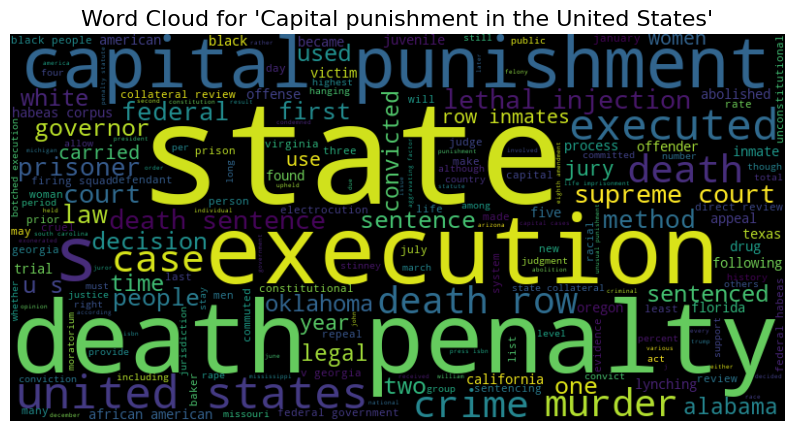

In [16]:
import wikipediaapi
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

wikipedia_api = wikipediaapi.Wikipedia(
    language='en',
    user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
)

def get_wikipedia_text(topic):
    page = wikipedia_api.page(topic)
    if page.exists():
        print(f"Extracting content from: {topic}")
        return clean_text(page.text)
    else:
        print(f"Page '{topic}' does not exist.")
        return ""

def create_word_cloud(text, topic):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for '{topic}'", fontsize=16)
    plt.show()

def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  
    text = re.sub(r'\W+', ' ', text)    
    text = re.sub(r'\d+', '', text)   
    return text.lower().strip()

selected_topics = ["Capital punishment in the United States"]

for topic in selected_topics:
    text = get_wikipedia_text(topic)
    if text:
        create_word_cloud(text, topic)


[@wiki_capital_punishment]

# Summary

In collecting data for this project, I combined information from different sources to create a detailed dataset on the death penalty. Along with analyzing text from Wikipedia to understand public sentiment and history, I added raw CSV files that include key details like which states have the death penalty, the race of exonerees and victims, county-level data, and sentence lengths. This comprehensive dataset gives a clear picture of the factors and patterns surrounding the death penalty in the U.S.

## Challenges

- Exoneree details were not present on the main listing page and required navigating to individual pages by clicking on the exoneree's name. I identified the pattern in the URL structure and looped through a pre-defined list of names to directly access individual pages.
- As a beginner in web scraping, understanding the technical concepts of HTML structure, XPath, and CSS selectors was initially overwhelming. I leveraged Large Language Models (LLMs) to learn the foundational concepts of web scraping.

## Benchmarks

- Webscraped exoneree cases from The Innocence Project.
- Webscraped petitions on the death penalty.
- Generated a word cloud from words extracted from Wikipedia.
- Collected additional datasets online without scraping, including execution records, demographic data, and state-level statistics.

## Future Steps

- Clean and preprocess collected data for consistency and usability.

## All Datasets Used and Collected

The dataset represents a comprehensive collection of capital punishment information in the United States, integrating multiple key sources. The core data includes case details through sentences.csv and nationwide outcome statistics, providing baseline metrics for analysis. A significant portion focuses on wrongful convictions and exonerations through two detailed Innocence Project datasets, capturing both death penalty-specific cases and their broader case database. The execution data is particularly extensive, containing historical records through executions_database.csv, documented cases of botched executions, and a complete execution record. The dataset also maintains forward-looking data with scheduled executions planned through 2027. Geographic and demographic analysis is enabled through county-level data (counties.csv) and state policy information (has_death_penalty.csv). The inclusion of GSS2002 survey data provides valuable public opinion context, while the petitions_descriptions.csv offers insights into advocacy and public discourse surrounding capital punishment.

[Download sentences.csv](../../data/raw-data/sentences.csv)

[Download sentence_outcomes_nationally.csv](../../data/raw-data/sentence_outcomes_nationally.csv)

[Download petitions_descriptions.csv](../../data/raw-data/petitions_descriptions.csv)

[Download innocence-project-death-penalty-cases.csv](../../data/raw-data/innocence-project-death-penalty-cases.csv)

[Download innocence-project-all-cases.csv](../../data/raw-data/innocence-project-all-cases.csv)

[Download has_death_penalty.csv](../../data/raw-data/has_death_penalty.csv)

[Download GSS2002.csv](../../data/raw-data/GSS2002.csv)

[Download executions_database.csv](../../data/raw-data/executions_database.csv)

[Download counties.csv](../../data/raw-data/counties.csv)

[Download botched_executions.csv](../../data/raw-data/botched_executions.csv)

[Download all_executions.csv](../../data/raw-data/all_executions.csv)

[Download 2027_scheduled_executions.csv](../../data/raw-data/2027_scheduled_executions.csv)

[Download 2026_scheduled_executions.csv](../../data/raw-data/2026_scheduled_executions.csv)

[Download 2025_scheduled_executions.csv](../../data/raw-data/2025_scheduled_executions.csv)

[Download 2024_remaining_executions.csv](../../data/raw-data/2024_remaining_executions.csv)
